# Importing Library

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model, Sequential 

early_stopping = EarlyStopping(patience=10)

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

np.random.seed(777)

print(tf.__version__)

Using TensorFlow backend.


1.5.1


##  Functions library

In [2]:
# prediction
def check_correct(predict, y):
    result = {}
    result['resistant-correct'] = 0
    result['resistant-wrong'] = 0
    result['sensitive-correct'] = 0
    result['sensitive-wrong'] = 0

    for i in range(len(predict)) :
        if predict[i] == y[i] :
            if y[i] == 0 :
                result['sensitive-correct'] += 1
            else :
                result['resistant-correct'] += 1
        else :
            if y[i] == 0 :
                result['sensitive-wrong'] += 1
            else :
                result['resistant-wrong'] += 1

    #for result_k, result_v in result.items():
    #    print(result_k +" : "+ str(result_v))
    sensitivity=result['resistant-correct']/(result['resistant-correct']+result['resistant-wrong'])
    specificity=result['sensitive-correct']/(result['sensitive-correct']+result['sensitive-wrong'])
    #print("Sensitivity :", sensitivity)
    #print("Specificity :", specificity)
    return sensitivity, specificity

In [3]:
# devide raw data into train / test & x_val / y_val
def data_split(raw_data, index_col, test_index):
    
    train_data = raw_data.iloc[list(raw_data.iloc[:,index_col]!=test_index)]
    test_data = raw_data.iloc[list(raw_data.iloc[:,index_col]==test_index)]
    
    y_val = train_data.Platinum_Status
    x_val = train_data.drop(["Platinum_Status","index"],axis=1)
    test_y_val = test_data.Platinum_Status
    test_x_val = test_data.drop(["Platinum_Status","index"],axis=1)
    
    return train_data, test_data, y_val, x_val, test_y_val, test_x_val

    # raw_data: have gene_expressions(maybe multiple columns), index column, Platinum_Status column.


In [4]:
# calculate all of model performance 
# - predictions(probability) / labeled predictions(0/1) / Loss / Accuracy / Sensitivity / Specificity / AUC values of Train / Test dataset.
# using trained models, or you can put predictions(probability) passively(in this case, Loss & Accuracy do not provided.)
def model_performance(information=False, Input_Prediction_Passively=False, using_model=None, tr_predictions=None, ts_predictions=None, tr_x_val=None, tr_y_val=None, ts_x_val=None, ts_y_val=None, output_list=None):
    
    if information == True:            
        print("options model_performance:\n1) using_model: keras models that you want to check performance. \"Input_Prediction_Passive\" option for input prediction list instead using models.\n3) tr_predictions & ts_predictions: prediction input passively. put this data only when not using keras model.\n4) tr_x_val & ts_x_val: input samples of train/test samples.\n4) tr_y_val & ts_y_val: results of train/test samples.\n5) output_list: return values that you want to recieve.\n CAUTION: Essential variable.\n\t tr_loss, tr_accuracy, tr_sensitivity, tr_specificity, tr_predictions, labeled_tr_predictions, tr_predictions_flat, roc_auc_tr,\nts_loss, ts_accuracy, ts_sensitivity, ts_specificity, ts_predictions, labeled_ts_predictions, ts_predictions_flat, roc_auc_ts,\nroc_auc_total\n\n* CAUTION: if 'None' value is returned, please check your input tr inputs(None value for tr outputs) or ts inputs(None value for ts outputs).") 
        return 0
    elif information != False:
        print("for using information options, please set 'information' variable for 'True'")
        return -1
    
    if using_model is None:
        if Input_Prediction_Passively == False:
            print("ERROR: There are no models for using.\nusing \"model_performance(information = True)\" for getting informations of this function.") 
            return -1
        elif (tr_predictions is None) and (ts_predictions is None): # No model/prediction input. no performance should be calculated.
                print("ERROR: Input prediction list instead using saved model.")
                return -1
        else: # No model input, but Input_Prediction_Passively is True & input prediction is valid.
            tr_loss,tr_accuracy= None, None
            ts_loss,ts_accuracy= None, None
            
    elif Input_Prediction_Passively == True: # both of model/prediction putted, could cause confusing.
        ch = input("You put both model and prediction. Select one method:\n'p' for using prediction only, 'm' using models only, 'n' for quit the function.")
        while 1:
            if ch == 'p':
                using_model = None
                break
            elif ch == 'm':
                tr_predictions = None
                ts_predictions = None
                break
            elif ch == 'e':
                return 0
            else:
                print("you put worng option: "+str(ch))
            ch = input("Select one method:\n'p' for using prediction only, 'm' using models only, 'n' for quit the function.")
                
    if output_list is None:
        print("ERROR: There are no output_list for return.\nusing \"model_performance(information = True)\" for getting informations of this function.")
        return -1
    
    if not(tr_x_val is None) and not(tr_y_val is None):
        # predict tr result only when no tr_prediction input
        if tr_predictions is None:
            tr_loss,tr_accuracy= using_model.evaluate(tr_x_val,tr_y_val)
            tr_predictions = using_model.predict(tr_x_val)
        # tr sensitivity / specificity
        labeled_tr_predictions = np.where(tr_predictions > 0.5, 1, 0).flatten()
        tr_sensitivity, tr_specificity = check_correct(labeled_tr_predictions, tr_y_val)
        tr_predictions_flat = tr_predictions[:,0]   
        # roc(tr)
        fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(tr_y_val, tr_predictions)
        roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)
    
    if not(ts_x_val is None) and not(ts_y_val is None):
        # predict ts result only when no ts_prediction input
        if ts_predictions is None:
            ts_loss,ts_accuracy= using_model.evaluate(ts_x_val,ts_y_val)
            ts_predictions = using_model.predict(ts_x_val)
        labeled_ts_predictions = np.where(ts_predictions > 0.5, 1, 0).flatten()
        ts_sensitivity, ts_specificity = check_correct(labeled_ts_predictions, ts_y_val)
        ts_predictions_flat = ts_predictions[:,0]   
        # roc(ts)
        fpr_ts, tpr_ts, threshold_ts = metrics.roc_curve(ts_y_val, ts_predictions)
        roc_auc_ts = metrics.auc(fpr_ts, tpr_ts)    
    
    if (not(tr_x_val is None) and not(tr_y_val is None)) and (not(ts_x_val is None) and not(ts_y_val is None)):
        y_true = np.append(tr_y_val, ts_y_val)
        y_pred = np.append(tr_predictions, ts_predictions)
        fpr_total, tpr_total, threshold_total = metrics.roc_curve(y_true, y_pred)
        roc_auc_total = metrics.auc(fpr_total, tpr_total)
        
        
    return_list = []
    
    for output in output_list:
        
        if(output == "tr_loss"):
            return_list.append(tr_loss)
                               
        elif(output == "tr_accuracy"):
            return_list.append(tr_accuracy)
                               
        elif(output == "tr_sensitivity"):
            return_list.append(tr_sensitivity)
                               
        elif(output == "tr_specificity"):
            return_list.append(tr_specificity)
                               
        elif(output == "tr_predictions"):
            return_list.append(tr_predictions)
                               
        elif(output == "labeled_tr_predictions"):
            return_list.append(labeled_tr_predictions)
                               
        elif(output == "tr_predictions_flat"):
            return_list.append(tr_predictions_flat)
            
        elif(output == "roc_auc_tr"):
            return_list.append(roc_auc_tr)

        elif(output == "ts_loss"):
            return_list.append(ts_loss)
                               
        elif(output == "ts_accuracy"):
            return_list.append(ts_accuracy)
                               
        elif(output == "ts_sensitivity"):
            return_list.append(ts_sensitivity)
                               
        elif(output == "ts_specificity"):
            return_list.append(ts_specificity)
                               
        elif(output == "ts_predictions"):
            return_list.append(ts_predictions)
                               
        elif(output == "labeled_ts_predictions"):
            return_list.append(labeled_ts_predictions)
                               
        elif(output == "ts_predictions_flat"):
            return_list.append(ts_predictions_flat)
        
        elif(output == "roc_auc_ts"):
            return_list.append(roc_auc_ts)
            
        elif(output == "roc_auc_total"):
            return_list.append(roc_auc_total)
                               
        else:
            print("There are no options <"+str(output)+">. Please refer these output options:\ntr_loss, tr_accuracy, tr_sensitivity, tr_specificity, tr_predictions, labeled_tr_predictions, tr_predictions_flat, roc_auc_tr,\nts_loss, ts_accuracy, ts_sensitivity, ts_specificity, ts_predictions, labeled_ts_predictions, ts_predictions_flat, roc_auc_ts,\nroc_auc_total")
    
    return return_list

# 1. Preparation: import & preprocessing data + import module

## Input path & name of models / raw data for ensemble

In [9]:
types = ["OV_Annotation3000_400_idx12", "OV_CV_400_idx12", 
         "OV_Var_400_idx12", "OV_new_Diff_400_idx12",
         "OV_Clin_idx12", 
         "OV_SNV_idx12" 
         ]

# input pathes
path = "C:/test/TC_subsamples_idx12/"
save_model_path = "../models/Ovary"
save_prediction_path = "../result/"

## Import Data

In [10]:
file_1 = path+types[0]+".csv"
file_2 = path+types[1]+".csv"
file_3 = path+types[2]+".csv"
file_4 = path+types[3]+".csv"
file_5 = path+types[4]+".csv"
file_6 = path+types[5]+".csv"

idx_col = 0

data_1 = pd.read_csv(file_1,index_col=idx_col)
data_2 = pd.read_csv(file_2,index_col=idx_col)
data_3 = pd.read_csv(file_3,index_col=idx_col)
data_4 = pd.read_csv(file_4,index_col=idx_col)
data_5 = pd.read_csv(file_5,index_col=idx_col)
data_6 = pd.read_csv(file_6,index_col=idx_col)

sample_1,features_1 = data_1.shape
sample_2,features_2 = data_2.shape
sample_3,features_3 = data_3.shape
sample_4,features_4 = data_4.shape
sample_5,features_5 = data_5.shape
sample_6,features_6 = data_6.shape

# Data frame include index & Platinum_Status column, substract 2 to calculate real number of features 
[features_1, features_2, features_3, features_4, features_5, features_6] = [features_1-2, features_2-2, features_3-2, features_4-2, features_5-2, features_6-2]

print("[1] file_name: ", types[0], "\nsample : {}  \nfeatures : {}".format(sample_1,features_1))
print("[2] file_name: ", types[1], "\nsample : {}  \nfeatures : {}".format(sample_2,features_2))
print("[3] file_name: ", types[2], "\nsample : {}  \nfeatures : {}".format(sample_3,features_3))
print("[4] file_name: ", types[3], "\nsample : {}  \nfeatures : {}".format(sample_4,features_4))
print("[5] file_name: ", types[4], "\nsample : {}  \nfeatures : {}".format(sample_5,features_5))
print("[6] file_name: ", types[5], "\nsample : {}  \nfeatures : {}".format(sample_6,features_6))

# Split Train Test Data

train_data_1, test_data_1, y_val_1, x_val_1, test_y_val_1, test_x_val_1 = data_split(raw_data = data_1, index_col = -1, test_index = 1)
train_data_2, test_data_2, y_val_2, x_val_2, test_y_val_2, test_x_val_2 = data_split(raw_data = data_2, index_col = -1, test_index = 1)
train_data_3, test_data_3, y_val_3, x_val_3, test_y_val_3, test_x_val_3 = data_split(raw_data = data_3, index_col = -1, test_index = 1)
train_data_4, test_data_4, y_val_4, x_val_4, test_y_val_4, test_x_val_4 = data_split(raw_data = data_4, index_col = -1, test_index = 1)
train_data_5, test_data_5, y_val_5, x_val_5, test_y_val_5, test_x_val_5 = data_split(raw_data = data_5, index_col = -1, test_index = 1)
train_data_6, test_data_6, y_val_6, x_val_6, test_y_val_6, test_x_val_6 = data_split(raw_data = data_6, index_col = -1, test_index = 1)

[1] file_name:  OV_Annotation3000_400_idx12 
sample : 217  
features : 400
[2] file_name:  OV_CV_400_idx12 
sample : 217  
features : 400
[3] file_name:  OV_Var_400_idx12 
sample : 217  
features : 400
[4] file_name:  OV_new_Diff_400_idx12 
sample : 217  
features : 400
[5] file_name:  OV_Clin_idx12 
sample : 287  
features : 35
[6] file_name:  OV_SNV_idx12 
sample : 213  
features : 6970


# Build & Evaluate models

## 1) Model 1

In [14]:
print("Model 1: "+str(types[0]))

# 1) parameter setting
adam = optimizers.Adam(lr=0.01)
input_drop_out_m_1 = 0.3
drop_out_m_1 = 0.5
layers = [5]
m_1_tr_loss_best = 100 # for saving best loss value 
best_m_1_model=[] #for saving best model
count=0 # for early stopping

# 2) model build
input_m_1 = Input(shape=(features_1,))
m_1_m_dp = Dropout(input_drop_out_m_1)(input_m_1)
for i in layers:
    m_1_m = Dense(i,activation='relu')(m_1_m_dp)
    m_1_m_dp = Dropout(drop_out_m_1)(m_1_m)
m_1_m_final = m_1_m_dp
output_m_1 = Dense(1, activation="sigmoid")(m_1_m_final)
m_1_model = Model(inputs=input_m_1,outputs=output_m_1)
m_1_model.compile(optimizer=adam, 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.
while 1:
    m_1_model.fit(x_val_1, y_val_1, batch_size=5, nb_epoch=1)
    m_1_tr_loss=m_1_model.evaluate(x_val_1,y_val_1)[0]
    if m_1_tr_loss < m_1_tr_loss_best: # new best model. count reset.
        m_1_tr_loss_best = m_1_tr_loss
        count=0
        best_m_1_model = m_1_model
    if count>3: # no increase three time. stop.
        m_1_model = best_m_1_model
        break
    else: count=count+1
print("Model 1 trained.")

# 4) save model
m_1_model.save(save_model_path+"/m_1.h5")
print("Model 1 saved.")

# 5) evaluate model
m_1_output_list = model_performance(
    information = False, using_model=m_1_model,Input_Prediction_Passively = False, 
    tr_x_val=x_val_1, tr_y_val=y_val_1, ts_x_val=test_x_val_1, ts_y_val=test_y_val_1,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

m_1_tr_loss, m_1_tr_accuracy, m_1_tr_sensitivity, m_1_tr_specificity, m_1_tr_predictions, m_1_labeled_tr_predictions, m_1_tr_predictions_flat, m_1_roc_auc_tr, m_1_ts_loss, m_1_ts_accuracy, m_1_ts_sensitivity, m_1_ts_specificity, m_1_ts_predictions,m_1_labeled_ts_predictions, m_1_ts_predictions_flat, m_1_roc_auc_ts, m_1_roc_auc_total = m_1_output_list

print("Overall AUC: ", m_1_roc_auc_total)
print("Train AUC: ", m_1_roc_auc_tr)
print("Test AUC: ", m_1_roc_auc_ts)

print("Train Accuracy: {}".format(m_1_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(m_1_tr_sensitivity)+", "+str(m_1_tr_specificity))
print("Test Accuracy: {}".format(m_1_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(m_1_ts_sensitivity)+", "+str(m_1_ts_specificity))

Model 1: OV_Annotation3000_400_idx12


c:\users\hgh97\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
186/186 [==============================] - 0s 429us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 59us/step
Epoch 1/1
186/186 [==============================] - 0s 64us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 64us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 97us/step
Epoch 1/1
186/186 [==============================] - 0s 64us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 97us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1

## 2) Model 2

In [19]:
print("Model_2: "+str(types[0]))

# 1) parameter setting
adam = optimizers.Adam(lr=0.01)
input_drop_out_m_2 = 0.3
drop_out_m_2 = 0.5
layers = [5]
m_2_tr_loss_best = 100 # for saving best loss value 
best_m_2_model=[] #for saving best model
count=0 # for early stopping

# 2) model build
input_m_2 = Input(shape=(features_2,))
m_2_m_dp = Dropout(input_drop_out_m_2)(input_m_2)
for i in layers:
    m_2_m = Dense(i,activation='relu')(m_2_m_dp)
    m_2_m_dp = Dropout(drop_out_m_2)(m_2_m)
m_2_m_final = m_2_m_dp
output_m_2 = Dense(1, activation="sigmoid")(m_2_m_final)
m_2_model = Model(inputs=input_m_2,outputs=output_m_2)
m_2_model.compile(optimizer=adam, 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.
while 1:
    m_2_model.fit(x_val_2, y_val_2, batch_size=5, nb_epoch=1)
    m_2_tr_loss=m_2_model.evaluate(x_val_2,y_val_2)[0]
    if m_2_tr_loss < m_2_tr_loss_best: # new best model. count reset.
        m_2_tr_loss_best = m_2_tr_loss
        count=0
        best_m_2_model = m_2_model
    if count>3: # no increase three time. stop.
        m_2_model = best_m_2_model
        break
    else: count=count+1
print("Model_2 trained.")

# 4) save model
m_2_model.save(save_model_path+"/m_2.h5")
print("Model_2 saved.")

# 5) evaluate model
m_2_output_list = model_performance(
    information = False, using_model=m_2_model,Input_Prediction_Passively = False, 
    tr_x_val=x_val_2, tr_y_val=y_val_2, ts_x_val=test_x_val_2, ts_y_val=test_y_val_2,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

m_2_tr_loss, m_2_tr_accuracy, m_2_tr_sensitivity, m_2_tr_specificity, m_2_tr_predictions, m_2_labeled_tr_predictions, m_2_tr_predictions_flat, m_2_roc_auc_tr, m_2_ts_loss, m_2_ts_accuracy, m_2_ts_sensitivity, m_2_ts_specificity, m_2_ts_predictions,m_2_labeled_ts_predictions, m_2_ts_predictions_flat, m_2_roc_auc_ts, m_2_roc_auc_total = m_2_output_list

print("Overall AUC: ", m_2_roc_auc_total)
print("Train AUC: ", m_2_roc_auc_tr)
print("Test AUC: ", m_2_roc_auc_ts)

print("Train Accuracy: {}".format(m_2_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(m_2_tr_sensitivity)+", "+str(m_2_tr_specificity))
print("Test Accuracy: {}".format(m_2_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(m_2_ts_sensitivity)+", "+str(m_2_ts_specificity))

Model_2: OV_Annotation3000_400_idx12


c:\users\hgh97\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
186/186 [==============================] - 0s 922us/step
Epoch 1/1
186/186 [==============================] - 0s 107us/step
Epoch 1/1
186/186 [==============================] - 0s 91us/step
Epoch 1/1
186/186 [==============================] - 0s 80us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 86us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 177us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 145us/step
Epoch 1/1
186/186 [==============================] - 0s 59us/step
Epoch 1/1
186/186 [==============================] - 0s 91us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 91us/step
Epoch 

## 3) Model 3 

In [20]:
print("Model_3: "+str(types[0]))

# 1) parameter setting
adam = optimizers.Adam(lr=0.01)
input_drop_out_m_3 = 0.3
drop_out_m_3 = 0.5
layers = [5]
m_3_tr_loss_best = 100 # for saving best loss value 
best_m_3_model=[] #for saving best model
count=0 # for early stopping

# 2) model build
input_m_3 = Input(shape=(features_3,))
m_3_m_dp = Dropout(input_drop_out_m_3)(input_m_3)
for i in layers:
    m_3_m = Dense(i,activation='relu')(m_3_m_dp)
    m_3_m_dp = Dropout(drop_out_m_3)(m_3_m)
m_3_m_final = m_3_m_dp
output_m_3 = Dense(1, activation="sigmoid")(m_3_m_final)
m_3_model = Model(inputs=input_m_3,outputs=output_m_3)
m_3_model.compile(optimizer=adam, 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.
while 1:
    m_3_model.fit(x_val_3, y_val_3, batch_size=5, nb_epoch=1)
    m_3_tr_loss=m_3_model.evaluate(x_val_3,y_val_3)[0]
    if m_3_tr_loss < m_3_tr_loss_best: # new best model. count reset.
        m_3_tr_loss_best = m_3_tr_loss
        count=0
        best_m_3_model = m_3_model
    if count>3: # no increase three time. stop.
        m_3_model = best_m_3_model
        break
    else: count=count+1
print("Model_3 trained.")

# 4) save model
m_3_model.save(save_model_path+"/m_3.h5")
print("Model_3 saved.")

# 5) evaluate model
m_3_output_list = model_performance(
    information = False, using_model=m_3_model,Input_Prediction_Passively = False, 
    tr_x_val=x_val_3, tr_y_val=y_val_3, ts_x_val=test_x_val_3, ts_y_val=test_y_val_3,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

m_3_tr_loss, m_3_tr_accuracy, m_3_tr_sensitivity, m_3_tr_specificity, m_3_tr_predictions, m_3_labeled_tr_predictions, m_3_tr_predictions_flat, m_3_roc_auc_tr, m_3_ts_loss, m_3_ts_accuracy, m_3_ts_sensitivity, m_3_ts_specificity, m_3_ts_predictions,m_3_labeled_ts_predictions, m_3_ts_predictions_flat, m_3_roc_auc_ts, m_3_roc_auc_total = m_3_output_list

print("Overall AUC: ", m_3_roc_auc_total)
print("Train AUC: ", m_3_roc_auc_tr)
print("Test AUC: ", m_3_roc_auc_ts)

print("Train Accuracy: {}".format(m_3_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(m_3_tr_sensitivity)+", "+str(m_3_tr_specificity))
print("Test Accuracy: {}".format(m_3_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(m_3_ts_sensitivity)+", "+str(m_3_ts_specificity))

Model_3: OV_Annotation3000_400_idx12


c:\users\hgh97\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
186/186 [==============================] - 0s 584us/step
Epoch 1/1
186/186 [==============================] - 0s 113us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 62us/step
Epoch 1/1
186/186 [==============================] - 0s 86us/step
Epoch 1/1
186/186 [==============================] - 0s 107us/step
Epoch 1/1
186/186 [==============================] - 0s 64us/step
Epoch 1/1
186/186 [==============================] - 0s 113us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 209us/step
Model_3 trained.
Model_3 saved.
31/31 [==============================] - 0s 129us/step
Overall AUC:  0.7595341166769738
Train AUC:  0.8134820426487093
Test AUC:  0.398989898989899
Train Accuracy: 0.70967

## 4) Model 4

In [22]:
print("Model_4: "+str(types[0]))

# 1) parameter setting
adam = optimizers.Adam(lr=0.01)
input_drop_out_m_4 = 0.3
drop_out_m_4 = 0.5
layers = [5]
m_4_tr_loss_best = 100 # for saving best loss value 
best_m_4_model=[] #for saving best model
count=0 # for early stopping

# 2) model build
input_m_4 = Input(shape=(features_4,))
m_4_m_dp = Dropout(input_drop_out_m_4)(input_m_4)
for i in layers:
    m_4_m = Dense(i,activation='relu')(m_4_m_dp)
    m_4_m_dp = Dropout(drop_out_m_4)(m_4_m)
m_4_m_final = m_4_m_dp
output_m_4 = Dense(1, activation="sigmoid")(m_4_m_final)
m_4_model = Model(inputs=input_m_4,outputs=output_m_4)
m_4_model.compile(optimizer=adam, 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.
while 1:
    m_4_model.fit(x_val_4, y_val_4, batch_size=5, nb_epoch=1)
    m_4_tr_loss=m_4_model.evaluate(x_val_4,y_val_4)[0]
    if m_4_tr_loss < m_4_tr_loss_best: # new best model. count reset.
        m_4_tr_loss_best = m_4_tr_loss
        count=0
        best_m_4_model = m_4_model
    if count>3: # no increase three time. stop.
        m_4_model = best_m_4_model
        break
    else: count=count+1
print("Model_4 trained.")

# 4) save model
m_4_model.save(save_model_path+"/m_4.h5")
print("Model_4 saved.")

# 5) evaluate model
m_4_output_list = model_performance(
    information = False, using_model=m_4_model,Input_Prediction_Passively = False, 
    tr_x_val=x_val_4, tr_y_val=y_val_4, ts_x_val=test_x_val_4, ts_y_val=test_y_val_4,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

m_4_tr_loss, m_4_tr_accuracy, m_4_tr_sensitivity, m_4_tr_specificity, m_4_tr_predictions, m_4_labeled_tr_predictions, m_4_tr_predictions_flat, m_4_roc_auc_tr, m_4_ts_loss, m_4_ts_accuracy, m_4_ts_sensitivity, m_4_ts_specificity, m_4_ts_predictions,m_4_labeled_ts_predictions, m_4_ts_predictions_flat, m_4_roc_auc_ts, m_4_roc_auc_total = m_4_output_list

print("Overall AUC: ", m_4_roc_auc_total)
print("Train AUC: ", m_4_roc_auc_tr)
print("Test AUC: ", m_4_roc_auc_ts)

print("Train Accuracy: {}".format(m_4_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(m_4_tr_sensitivity)+", "+str(m_4_tr_specificity))
print("Test Accuracy: {}".format(m_4_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(m_4_ts_sensitivity)+", "+str(m_4_ts_specificity))

Model_4: OV_Annotation3000_400_idx12


c:\users\hgh97\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
186/186 [==============================] - 0s 598us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 86us/step
Epoch 1/1
186/186 [==============================] - 0s 80us/step
Epoch 1/1
186/186 [==============================] - 0s 86us/step
Epoch 1/1
186/186 [==============================] - 0s 91us/step
Epoch 1/1
186/186 [==============================] - 0s 97us/step
Epoch 1/1
186/186 [==============================] - 0s 102us/step
Epoch 1/1
186/186 [==============================] - 0s 80us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 102us/step
Epoch 1/1
186/186 [==============================] - 0s 75us/step
Epoch 1/1
186/186 [==============================] - 0s 97us/step
Epoch 1/1
186/186 [==============================] - 0s 70us/step
Epoch 1/1
186/186 [==============================] - 0s 102us/step
Model_

## 5) Model 5

In [21]:
print("Model_5: "+str(types[0]))

# 1) parameter setting
adam = optimizers.Adam(lr=0.01)
input_drop_out_m_5 = 0.3
drop_out_m_5 = 0.5
layers = [5]
m_5_tr_loss_best = 100 # for saving best loss value 
best_m_5_model=[] #for saving best model
count=0 # for early stopping

# 2) model build
input_m_5 = Input(shape=(features_5,))
m_5_m_dp = Dropout(input_drop_out_m_5)(input_m_5)
for i in layers:
    m_5_m = Dense(i,activation='relu')(m_5_m_dp)
    m_5_m_dp = Dropout(drop_out_m_5)(m_5_m)
m_5_m_final = m_5_m_dp
output_m_5 = Dense(1, activation="sigmoid")(m_5_m_final)
m_5_model = Model(inputs=input_m_5,outputs=output_m_5)
m_5_model.compile(optimizer=adam, 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.
while 1:
    m_5_model.fit(x_val_5, y_val_5, batch_size=5, nb_epoch=1)
    m_5_tr_loss=m_5_model.evaluate(x_val_5,y_val_5)[0]
    if m_5_tr_loss < m_5_tr_loss_best: # new best model. count reset.
        m_5_tr_loss_best = m_5_tr_loss
        count=0
        best_m_5_model = m_5_model
    if count>3: # no increase three time. stop.
        m_5_model = best_m_5_model
        break
    else: count=count+1
print("Model_5 trained.")

# 4) save model
m_5_model.save(save_model_path+"/m_5.h5")
print("Model_5 saved.")

# 5) evaluate model
m_5_output_list = model_performance(
    information = False, using_model=m_5_model,Input_Prediction_Passively = False, 
    tr_x_val=x_val_5, tr_y_val=y_val_5, ts_x_val=test_x_val_5, ts_y_val=test_y_val_5,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

m_5_tr_loss, m_5_tr_accuracy, m_5_tr_sensitivity, m_5_tr_specificity, m_5_tr_predictions, m_5_labeled_tr_predictions, m_5_tr_predictions_flat, m_5_roc_auc_tr, m_5_ts_loss, m_5_ts_accuracy, m_5_ts_sensitivity, m_5_ts_specificity, m_5_ts_predictions,m_5_labeled_ts_predictions, m_5_ts_predictions_flat, m_5_roc_auc_ts, m_5_roc_auc_total = m_5_output_list

print("Overall AUC: ", m_5_roc_auc_total)
print("Train AUC: ", m_5_roc_auc_tr)
print("Test AUC: ", m_5_roc_auc_ts)

print("Train Accuracy: {}".format(m_5_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(m_5_tr_sensitivity)+", "+str(m_5_tr_specificity))
print("Test Accuracy: {}".format(m_5_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(m_5_ts_sensitivity)+", "+str(m_5_ts_specificity))

Model_5: OV_Annotation3000_400_idx12


c:\users\hgh97\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
256/256 [==============================] - 0s 495us/step
Epoch 1/1
256/256 [==============================] - 0s 101us/step
Epoch 1/1
256/256 [==============================] - 0s 66us/step
Epoch 1/1
256/256 [==============================] - 0s 72us/step
Epoch 1/1
256/256 [==============================] - 0s 78us/step
Epoch 1/1
256/256 [==============================] - 0s 93us/step
Epoch 1/1
256/256 [==============================] - 0s 152us/step
Epoch 1/1
256/256 [==============================] - 0s 66us/step
Epoch 1/1
256/256 [==============================] - 0s 62us/step
Epoch 1/1
256/256 [==============================] - 0s 57us/step
Epoch 1/1
256/256 [==============================] - 0s 51us/step
Epoch 1/1
256/256 [==============================] - 0s 58us/step
Epoch 1/1
256/256 [==============================] - 0s 62us/step
Epoch 1/1
256/256 [==============================] - 0s 51us/step
Epoch 1/1
256/256 [==============================] - 0s 62us/step
Epoch 1

## 6) Model 6 

In [23]:
print("Model_6: "+str(types[0]))

# 1) parameter setting
adam = optimizers.Adam(lr=0.01)
input_drop_out_m_6 = 0.3
drop_out_m_6 = 0.5
layers = [5]
m_6_tr_loss_best = 100 # for saving best loss value 
best_m_6_model=[] #for saving best model
count=0 # for early stopping

# 2) model build
input_m_6 = Input(shape=(features_6,))
m_6_m_dp = Dropout(input_drop_out_m_6)(input_m_6)
for i in layers:
    m_6_m = Dense(i,activation='relu')(m_6_m_dp)
    m_6_m_dp = Dropout(drop_out_m_6)(m_6_m)
m_6_m_final = m_6_m_dp
output_m_6 = Dense(1, activation="sigmoid")(m_6_m_final)
m_6_model = Model(inputs=input_m_6,outputs=output_m_6)
m_6_model.compile(optimizer=adam, 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.
while 1:
    m_6_model.fit(x_val_6, y_val_6, batch_size=5, nb_epoch=1)
    m_6_tr_loss=m_6_model.evaluate(x_val_6,y_val_6)[0]
    if m_6_tr_loss < m_6_tr_loss_best: # new best model. count reset.
        m_6_tr_loss_best = m_6_tr_loss
        count=0
        best_m_6_model = m_6_model
    if count>3: # no increase three time. stop.
        m_6_model = best_m_6_model
        break
    else: count=count+1
print("Model_6 trained.")

# 4) save model
m_6_model.save(save_model_path+"/m_6.h5")
print("Model_6 saved.")

# 5) evaluate model
m_6_output_list = model_performance(
    information = False, using_model=m_6_model,Input_Prediction_Passively = False, 
    tr_x_val=x_val_6, tr_y_val=y_val_6, ts_x_val=test_x_val_6, ts_y_val=test_y_val_6,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

m_6_tr_loss, m_6_tr_accuracy, m_6_tr_sensitivity, m_6_tr_specificity, m_6_tr_predictions, m_6_labeled_tr_predictions, m_6_tr_predictions_flat, m_6_roc_auc_tr, m_6_ts_loss, m_6_ts_accuracy, m_6_ts_sensitivity, m_6_ts_specificity, m_6_ts_predictions,m_6_labeled_ts_predictions, m_6_ts_predictions_flat, m_6_roc_auc_ts, m_6_roc_auc_total = m_6_output_list

print("Overall AUC: ", m_6_roc_auc_total)
print("Train AUC: ", m_6_roc_auc_tr)
print("Test AUC: ", m_6_roc_auc_ts)

print("Train Accuracy: {}".format(m_6_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(m_6_tr_sensitivity)+", "+str(m_6_tr_specificity))
print("Test Accuracy: {}".format(m_6_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(m_6_ts_sensitivity)+", "+str(m_6_ts_specificity))

Model_6: OV_Annotation3000_400_idx12


c:\users\hgh97\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
182/182 [==============================] - 0s 1ms/step
Epoch 1/1
182/182 [==============================] - 0s 225us/step
Epoch 1/1
182/182 [==============================] - 0s 236us/step
Epoch 1/1
182/182 [==============================] - 0s 186us/step
Epoch 1/1
182/182 [==============================] - 0s 304us/step
Epoch 1/1
182/182 [==============================] - 0s 186us/step
Epoch 1/1
182/182 [==============================] - 0s 230us/step
Epoch 1/1
182/182 [==============================] - 0s 348us/step
Epoch 1/1
182/182 [==============================] - 0s 241us/step
Epoch 1/1
182/182 [==============================] - 0s 219us/step
Epoch 1/1
182/182 [==============================] - 0s 225us/step
Epoch 1/1
182/182 [==============================] - 0s 214us/step
Epoch 1/1
182/182 [==============================] - 0s 367us/step
Epoch 1/1
182/182 [==============================] - 0s 225us/step
Epoch 1/1
182/182 [==============================] - 0s 214us/st

## Performance Comparison

In [37]:
label = []
tr_accuracy_list = [m_1_tr_accuracy, m_2_tr_accuracy, m_3_tr_accuracy, m_4_tr_accuracy, m_5_tr_accuracy, m_6_tr_accuracy]
ts_accuracy_list = [m_1_ts_accuracy, m_2_ts_accuracy, m_3_ts_accuracy, m_4_ts_accuracy, m_5_ts_accuracy, m_6_ts_accuracy]

for i in range(1,7):
    label.append("model"+str(i))

for model_num in range(len(label)):
    print("< "+label[model_num]+" > tr: "+str(tr_accuracy_list[model_num])+", ts: "+str(ts_accuracy_list[model_num]))

< model1 > tr: 0.7096774219184794, ts: 0.7096773982048035
< model2 > tr: 0.9516129038667166, ts: 0.5483871102333069
< model3 > tr: 0.7096774219184794, ts: 0.7096773982048035
< model4 > tr: 0.7096774219184794, ts: 0.7096773982048035
< model5 > tr: 0.69140625, ts: 0.7096773982048035
< model6 > tr: 1.0, ts: 0.774193525314331


In [43]:
def plot_bar_x():
    # this is for plotting purpose
    plt.figure(figsize=(30,20))
    axes = plt.gca()
    axes.set_ylim([min(ts_accuracy_list)-0.02, max(ts_accuracy_list)+0.02])
    index = np.arange(len(label))
    plt.bar(index, ts_accuracy_list,color=['red', 'orange', 'yellow', "green",'blue', 'purple'],alpha=0.5,width=0.3)
    plt.xlabel('Method', fontsize=35)
    plt.ylabel('Accuracy', fontsize=35)
    plt.yticks(fontsize=30)    
    plt.xticks(index, types, fontsize=30, rotation=90)
    plt.title('Performance Comparison for each Models',fontsize=40)
    plt.show()

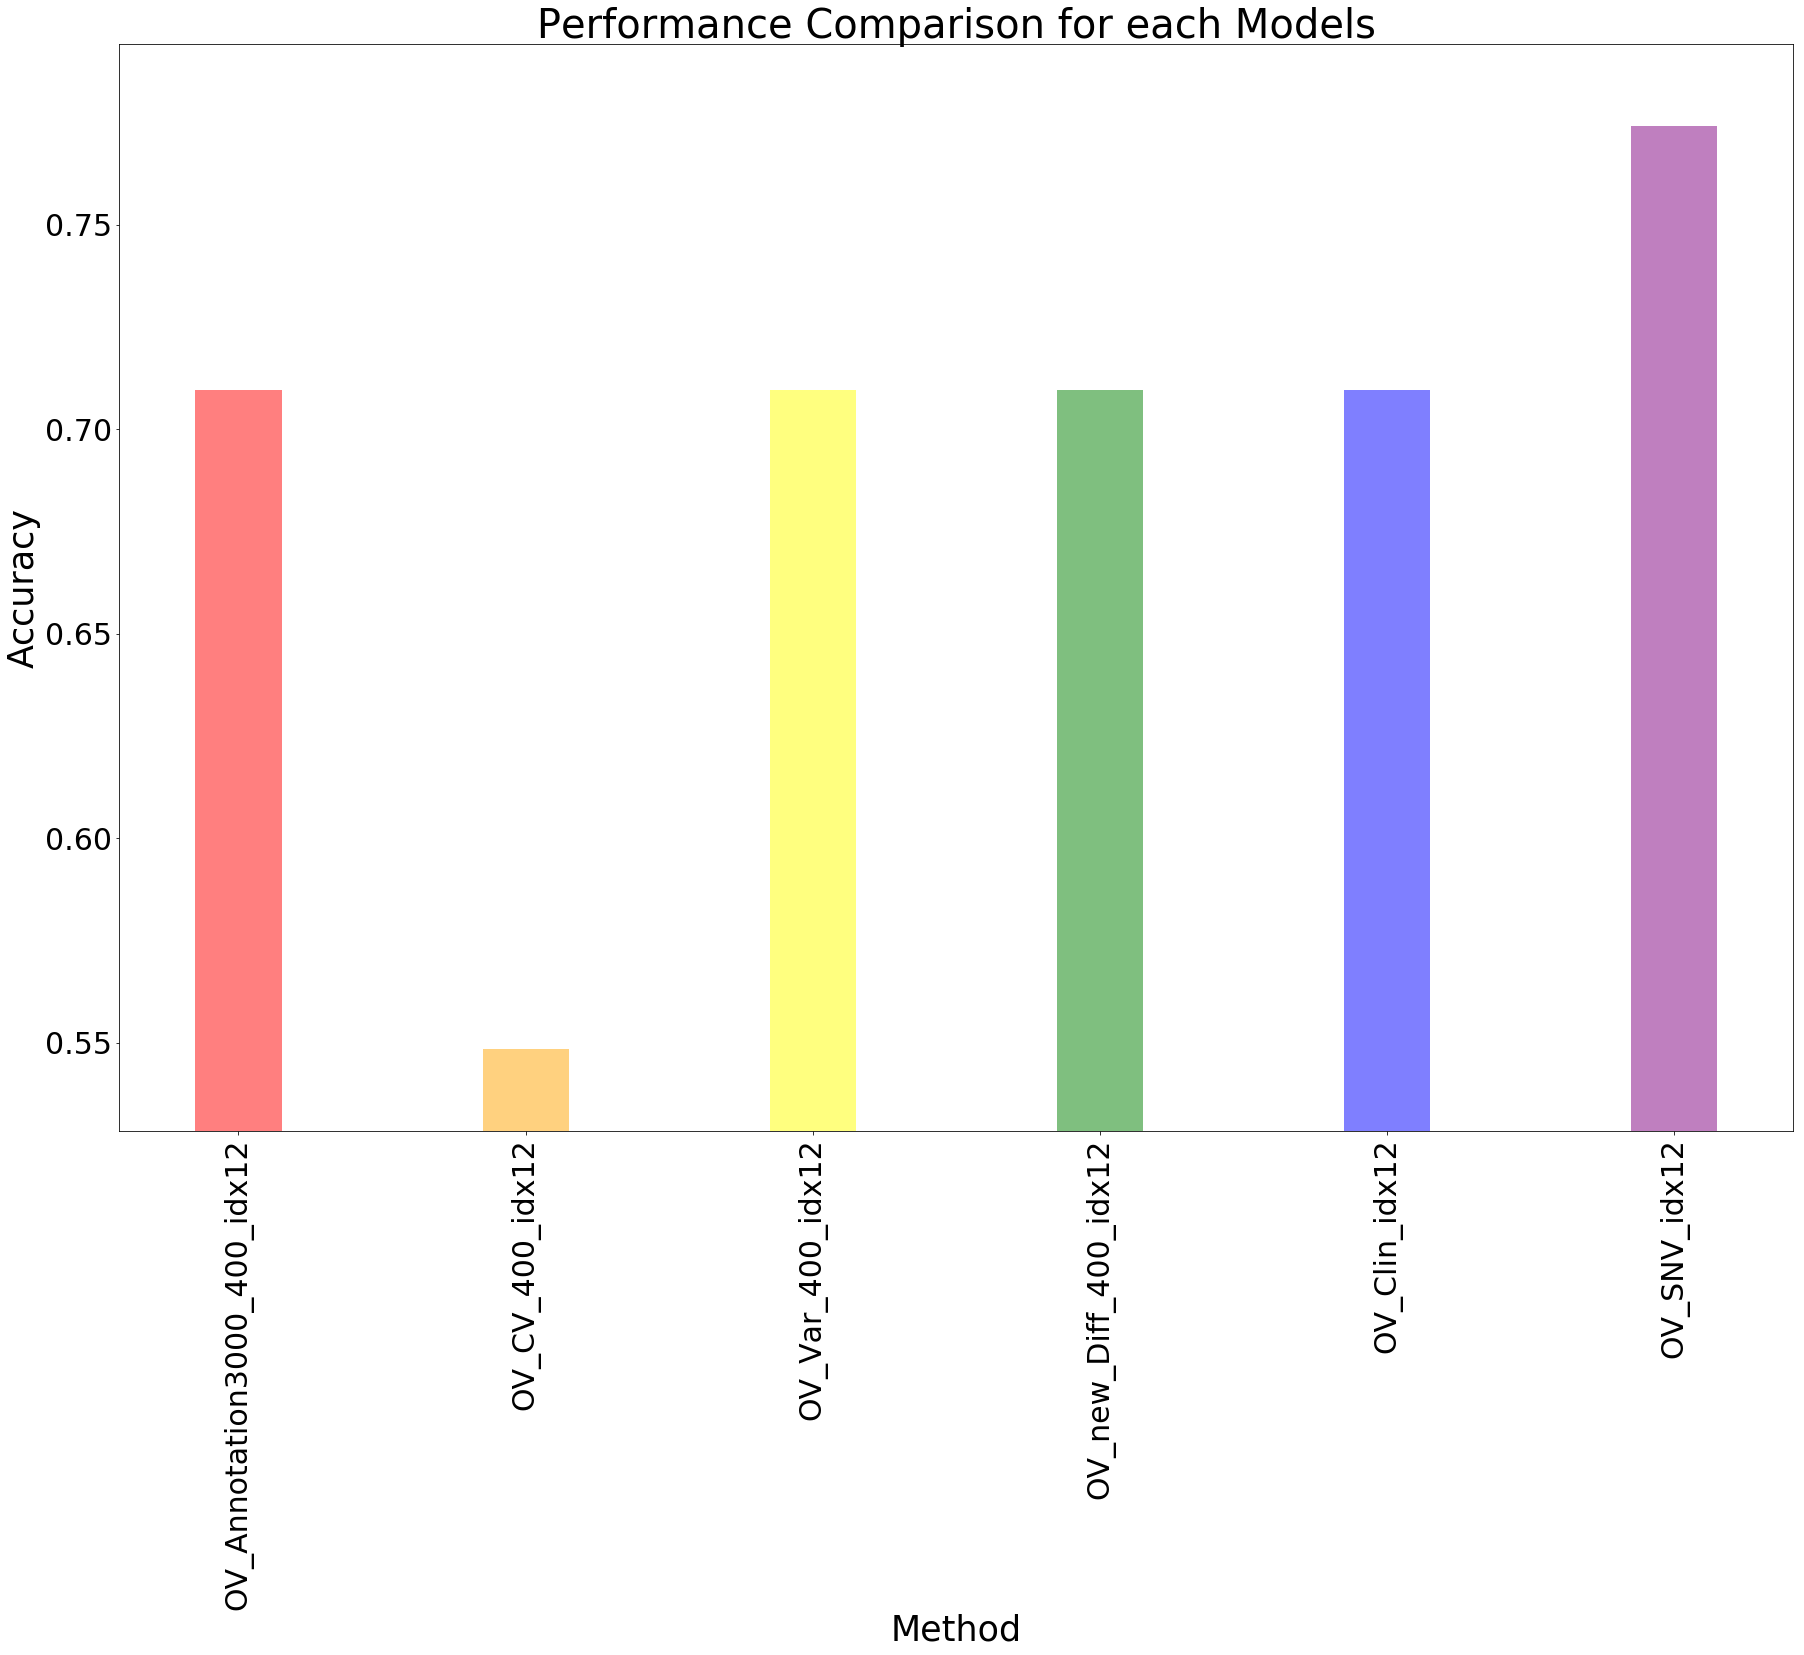

In [44]:
plot_bar_x()